The aim of this notebook is to act as a central hub, within which all of the detectors presented in the supporting notebooks are directly compared.

In [1]:
# First, imports
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve
# for Manhattan detector, need cityblock distance
from scipy.spatial.distance import cityblock
from itertools import zip_longest
# for plot formatting
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [2]:
# Read in csv file and check what's inside
df = pd.read_csv('DSL-StrongPasswordData.csv')
subjects = df["subject"].unique()

In [23]:
# Define a general Manhattan class capable of producing various models

# Variables:
# df - the dataframe 
# subjects - unique subjects within the dataframe
# useFilter - boolean - controls whether to apply a filter to the training vector
# featExclRegex - string - regex through which features in the dataframe can be excluded from training
# mean_vector - np.array(float) - mean values of training data
# user_dists - list(float) - cityblock distances computed while testing on genuine user data
# imposter_dists - list(float) - cityblock distances computed while testing on imposter user data
# eer_list - list(float) - contains eer of each model iteration
# eer_average - float - model average eer
# eer_average_std - float - model average eer std deviation
# fpr_thresh - np.array(float) - fixed list of fpr values from which interpolated tpr values can be calculated (roc_curve returns fpr/tpr lists of differing length between iterations)
# interp_tpr_lst - list(float) - interpolated tpr values (calculated wrt fpr_thresh)
# tpr_lower - np.array(float) - interp_tpr_list.mean - interp_tpr_list.stddev
# tpr_upper - np.array(float) - interp_tpr_list.mean + interp_tpr_list.stddev
# training_data - df - data used to train model
# genuine_user_data - df - genuine user data used to test model
# imposter_user_data - df - genuine imposter data used to test model


class Manhattan:
    def __init__(self, df, useFilter, featExclRegex):
        self.df = df
        self.subjects = df["subject"].unique()
        self.useFilter = useFilter
        self.featExclRegex = featExclRegex
        self.mean_vector = []
        self.user_dists = []
        self.imposter_dists = []
        self.eer_list = []
        self.eer_average = 0.
        self.eer_average_std= 0.
        self.fpr_thresh = np.linspace(0,1,201)
        self.interp_tpr_lst = []
        self.tpr_lower = []
        self.tpr_upper = []
        # We lazily initialise these dataframes to the main one
        # This is to avoid defining these class variables in a function other than __init__ (which isn't something I like)
        self.training_data = df
        self.genuine_user_data = df
        self.imposter_user_data = df
            
    def train(self):
        self.mean_vector = self.training_data.mean().values
        
        if self.useFilter == True:
            std_vector = self.training_data.std().values
            # Remove values that are +/- 3 std dev from the mean, and form a robust mean vector from those left
            drop_indices = []
    
            for row in range(self.training_data.shape[0]):
                for feature in range(self.training_data.shape[1]):
                    if self.training_data.iloc[row].iloc[feature] > (self.mean_vector[feature]+3*std_vector[feature]) or self.training_data.iloc[row].iloc[feature] < (self.mean_vector[feature]-3*std_vector[feature]):
                        drop_indices.append(row)
                        break
            self.training_data = self.training_data.drop(self.training_data.index[drop_indices])
            self.mean_vector = self.training_data.mean().values  
        
        
    def test(self):
        # for each row (entry), compute cityblock distance between mean vector and test vector
        for i in range(self.genuine_user_data.shape[0]):
            dist = cityblock(self.genuine_user_data.iloc[i].values, self.mean_vector)
            self.user_dists.append(dist)
        for i in range(self.imposter_user_data.shape[0]):
            dist = cityblock(self.imposter_user_data.iloc[i].values, self.mean_vector)
            self.imposter_dists.append(dist)
        
    
    def evaluate(self):
        for subject in self.subjects:
            real_user = self.df.loc[self.df.subject == subject]
            fake_user = self.df.loc[self.df.subject != subject]
            
            self.training_data = real_user[:200].loc[:, 'H.period':'H.Return']

            # To test our model, we need both more data from the original user, and imposter user data
            self.genuine_user_data = real_user[200:].loc[:, 'H.period':'H.Return']

            self.imposter_user_data = fake_user[:].loc[:, 'H.period':'H.Return']
    
            if self.featExclRegex != "":
                self.training_data.drop(list(self.training_data.filter(regex = self.featExclRegex)), axis = 1, inplace = True)
                self.genuine_user_data.drop(list(self.genuine_user_data.filter(regex = self.featExclRegex)), axis = 1, inplace = True)
                self.imposter_user_data.drop(list(self.imposter_user_data.filter(regex = self.featExclRegex)), axis = 1, inplace = True)
    
            # Let's check dimensions of our training and testing tuples are the same...just in case
            if self.training_data.shape != self.genuine_user_data.shape:
                sys.exit("training_data and genuine_user_data shapes don't match: {} | {}".format(self.training_data.shape, self.genuine_user_data.shape))
            elif self.imposter_user_data.shape[0] != self.genuine_user_data.shape[0]*100:
                sys.exit("imposter_user_data and genuine_user_data rows aren't 20000 and 200: {} | {}".format(self.imposter_user_data.shape[0], self.genuine_user_data.shape[0]))

            self.train()
            self.test()
            
            # Time to compute equal error rates
            # Labels: 0 = user, 1 = imposter. We therefore need np arrays of 0s and 1s to same length as NSamples
            labels = [0]*len(self.user_dists) + [1]*len(self.imposter_dists)
            fpr, tpr, thresholds = roc_curve(labels, self.user_dists + self.imposter_dists) 

            # TPR = TP / (TP + FN) i.e. over total positives that shouldve been identified as true
            # FPR = FP / (FP + TN) i.e. over total negatives that shouldve been identified as true
            # TPR + FNR = 1
            # FPR + TNR = 1
            fnr = 1 - tpr
    
            # Equal error rate is where fnr = fpr (or minimum distance between them)      
            # So we calculate the absolute difference between fnr and fpr and find where that's minimised
            # Small differences are present depending on whether we do fnr[] or fpr[] as we aren't interpolating
            eer = fnr[np.nanargmin(np.absolute(fnr-fpr))]
            self.eer_list.append(eer)
    
            # Interpolate tpr values for this roc iteration, store in list
            self.interp_tpr_lst.append(np.interp(self.fpr_thresh,fpr,tpr))
            
        mean_tpr = np.mean(self.interp_tpr_lst,axis=0)
        std_tpr = np.std(self.interp_tpr_lst,axis=0)
        # for error bar propagation
        self.tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
        self.tpr_lower = mean_tpr - std_tpr
        
        self.eer_average = np.mean(self.eer_list)
        self.eer_average_std = np.std(self.eer_list, ddof=0)
 
    

In [28]:
# Define model instances
manhattan = Manhattan(df,False,"")
manhattanNoH = Manhattan(df,False,"H")
manhattanNoUD = Manhattan(df,False,"UD")
manhattanNoDD = Manhattan(df,False,"DD")
manhattanFiltered = Manhattan(df,True,"")
manhattanFilteredNoUD = Manhattan(df,True,"UD")

In [29]:
# Evaluate models
manhattan.evaluate()
manhattanNoH.evaluate()
manhattanNoUD.evaluate()
manhattanNoDD.evaluate()
manhattanFiltered.evaluate()
manhattanFilteredNoUD.evaluate()

In [62]:
# Compute average eer
np.set_printoptions(precision=3)
print("Detector | Average EER | Average EER Std Dev | % Improvement vs Manhattan")
print("Manhattan | %.3f | %.3f | -" % (manhattan.eer_average,manhattan.eer_average_std))
print("ManhattanNoH | %.3f | %.3f | %.3f" % (manhattanNoH.eer_average,manhattanNoH.eer_average_std,(manhattan.eer_average-manhattanNoH.eer_average)/manhattan.eer_average*100))
print("ManhattanNoUD | %.3f | %.3f | %.3f" % (manhattanNoUD.eer_average,manhattanNoUD.eer_average_std,(manhattan.eer_average-manhattanNoUD.eer_average)/manhattan.eer_average*100))
print("ManhattanNoDD | %.3f | %.3f | %.3f" % (manhattanNoDD.eer_average,manhattanNoDD.eer_average_std,(manhattan.eer_average-manhattanNoDD.eer_average)/manhattan.eer_average*100))
print("ManhattanFiltered | %.3f | %.3f | %.3f" % (manhattanFiltered.eer_average,manhattanFiltered.eer_average_std,(manhattan.eer_average-manhattanFiltered.eer_average)/manhattan.eer_average*100))
print("ManhattanFilteredNoUD | %.3f | %.3f | %.3f" % (manhattanFilteredNoUD.eer_average,manhattanFilteredNoUD.eer_average_std,(manhattan.eer_average-manhattanFilteredNoUD.eer_average)/manhattan.eer_average*100))



Detector | Average EER | Average EER Std Dev | % Improvement vs Manhattan
Manhattan | 0.299 | 0.016 | -
ManhattanNoH | 0.332 | 0.017 | -10.961
ManhattanNoUD | 0.270 | 0.013 | 9.871
ManhattanNoDD | 0.283 | 0.020 | 5.281
ManhattanFiltered | 0.255 | 0.016 | 14.629
ManhattanFilteredNoUD | 0.237 | 0.017 | 20.786


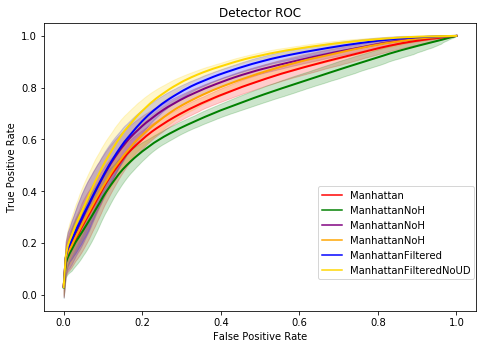

In [48]:
# Plot ROCs of different models
# This is obviously a lot of copy paste - plan to refactor into a function ASAP
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Detector ROC')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.plot(manhattan.fpr_thresh,np.mean(manhattan.interp_tpr_lst,axis=0),'red',ls='-',lw=2,label='Manhattan')
ax.fill_between(manhattan.fpr_thresh, manhattan.tpr_lower, manhattan.tpr_upper, color='red', alpha=0.2)
ax.plot(manhattanNoH.fpr_thresh,np.mean(manhattanNoH.interp_tpr_lst,axis=0),'green',ls='-',lw=2,label='ManhattanNoH')
ax.fill_between(manhattanNoH.fpr_thresh, manhattanNoH.tpr_lower, manhattanNoH.tpr_upper, color='green', alpha=0.2)
ax.plot(manhattanNoUD.fpr_thresh,np.mean(manhattanNoUD.interp_tpr_lst,axis=0),'purple',ls='-',lw=2,label='ManhattanNoUD')
ax.fill_between(manhattanNoUD.fpr_thresh, manhattanNoUD.tpr_lower, manhattanNoUD.tpr_upper, color='purple', alpha=0.2)
ax.plot(manhattanNoDD.fpr_thresh,np.mean(manhattanNoDD.interp_tpr_lst,axis=0),'orange',ls='-',lw=2,label='ManhattanNoDD')
ax.fill_between(manhattanNoDD.fpr_thresh, manhattanNoDD.tpr_lower, manhattanNoDD.tpr_upper, color='orange', alpha=0.2)
ax.plot(manhattanFiltered.fpr_thresh,np.mean(manhattanFiltered.interp_tpr_lst,axis=0),'blue',ls='-',lw=2,label='ManhattanFiltered')
ax.fill_between(manhattanFiltered.fpr_thresh, manhattanFiltered.tpr_lower, manhattanFiltered.tpr_upper, color='blue', alpha=0.2)
ax.plot(manhattanFilteredNoUD.fpr_thresh,np.mean(manhattanFilteredNoUD.interp_tpr_lst,axis=0),'gold',ls='-',lw=2,label='ManhattanFiltered')
ax.fill_between(manhattanFilteredNoUD.fpr_thresh, manhattanFilteredNoUD.tpr_lower, manhattanFilteredNoUD.tpr_upper, color='gold', alpha=0.2)

leg_mh = mlines.Line2D([],[],color='red',linestyle="-",label='Manhattan')
leg_mhH = mlines.Line2D([],[],color='green',linestyle="-",label='ManhattanNoH')
leg_mhUD = mlines.Line2D([],[],color='purple',linestyle="-",label='ManhattanNoH')
leg_mhDD = mlines.Line2D([],[],color='orange',linestyle="-",label='ManhattanNoH')
leg_mhF = mlines.Line2D([],[],color='blue',linestyle="-",label='ManhattanFiltered')
leg_mhFUD = mlines.Line2D([],[],color='gold',linestyle="-",label='ManhattanFilteredNoUD')

fig.legend(loc=[0.65,0.2],handles=[leg_mh,leg_mhH,leg_mhUD,leg_mhDD,leg_mhF,leg_mhFUD])

In [40]:
'''
# not finished but this is the logic
def compare_roc(detector_list):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_title('Manhattan ROC')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    leg_list = []
    for det in detector_list:
        ax.plot(det.fpr_thresh,np.mean(det.interp_tpr_lst,axis=0),'red',ls='-',lw=2,label='Manhattan')
        ax.fill_between(det.fpr_thresh, det.tpr_lower, det.tpr_upper, color='red', alpha=0.2)
        leg = mlines.Line2D([],[],color='red',linestyle="-",label='Manhattan')
        leg_list.append(leg)
    fig.legend(loc=[0.65,0.2],handles=[leg_list])   
'''
